# Fall Detection using SisFall Dataset
Daniela Dias, nMec 98039

In [40]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Utility functions for SisFall dataset

**ADXL345**
Resolution: 13 bits
Range: +-16g

**ITG3200**
Resolution: 16 bits
Range: +-2000?s

**MMA8451Q**
Resolution: 14 bits
Range: +-8g

In [41]:
ACCEL_ADXL345_RANGE = 16  # ±16g
ACCEL_ADXL345_RES = 13

GYRO_ITG3200_RANGE = 2000  # ±2000°/s
GYRO_ITG3200_RES = 16

ACCEL_MMA8451Q_RANGE = 8  # ±8g
ACCEL_MMA8451Q_RES = 14

In [42]:
# Accelerometer conversion functions
def convert_accel_adxl345(raw_bits):
    return (2 * ACCEL_ADXL345_RANGE / (2 ** ACCEL_ADXL345_RES)) * raw_bits


def convert_accel_mma8451q(raw_bits):
    return (2 * ACCEL_MMA8451Q_RANGE / (2 ** ACCEL_MMA8451Q_RES)) * raw_bits

In [43]:
# Gyroscope conversion function
def convert_gyro_itg3200(raw_bits):
    return (2 * GYRO_ITG3200_RANGE / (2 ** GYRO_ITG3200_RES)) * raw_bits

In [44]:
# Labeling function
def get_label_from_filename(filename):
    if filename.startswith('F'):
        return 'fall'
    elif filename.startswith('D'):
        return 'adl'
    else:
        return 'unknown'

## Reducing the dataset

The SisFall dataset is an extensive collection of high-frequency time-series recordings captured from wearable inertial sensors. It comprises over 4,500 individual recordings (files), each corresponding to a unique trial of a subject's specific activity. Given the 200 Hz sampling rate and the duration of each trial, the raw dataset exceeds 15 million time steps and spans over 30 distinct activity types across 38 participants. 

While this breadth and density make the dataset well-suited for in-depth modeling, it also introduces considerable computational overhead, particularly during preprocessing steps such as windowing, feature extraction, and deep learning model training. This issue is further amplified when hyperparameter tuning or cross-validation is employed, leading to long runtimes and high memory consumption.

In [45]:
# Load single file
def load_sisfall_file(filepath):
    raw_data = pd.read_csv(filepath, header=None, sep=',')

    # Remove trailing semicolon from each element
    raw_data = raw_data.map(lambda x: float(x.rstrip(';')) if isinstance(x, str) else x)

    data_converted = pd.DataFrame({
        'accel_adxl345_x': convert_accel_adxl345(raw_data[0]),
        'accel_adxl345_y': convert_accel_adxl345(raw_data[1]),
        'accel_adxl345_z': convert_accel_adxl345(raw_data[2]),

        'gyro_itg3200_x': convert_gyro_itg3200(raw_data[3]),
        'gyro_itg3200_y': convert_gyro_itg3200(raw_data[4]),
        'gyro_itg3200_z': convert_gyro_itg3200(raw_data[5]),

        'accel_mma8451q_x': convert_accel_mma8451q(raw_data[6]),
        'accel_mma8451q_y': convert_accel_mma8451q(raw_data[7]),
        'accel_mma8451q_z': convert_accel_mma8451q(raw_data[8])
    })

    label = get_label_from_filename(os.path.basename(filepath))
    data_converted['label'] = label

    return data_converted

In [46]:
# Load entire dataset
def load_sisfall_dataset(dataset_dir):
    dataset = []

    # Select the subjects to keep
    subjects_to_keep = [
        'SA01', 'SA02', 'SA03', 'SA05', 'SA06', 'SA07', 'SA08', 'SA09', 'SA10', 'SA11', 'SA12', 'SA13', 'SA14', 'SA15', 'SA16', 'SA17', 'SA18', 'SA19', 'SA20',
        'SE01', 'SE02', 'SE03', 'SE04', 'SE05', 'SE06'
    ]

    for subject_folder in os.listdir(dataset_dir):
        subject_path = os.path.join(dataset_dir, subject_folder)

        if subject_folder not in subjects_to_keep:
            continue

        if os.path.isdir(subject_path):
            for file in os.listdir(subject_path):
                if (file.endswith('.txt')
                        and (file.startswith('F') or file.startswith('D'))):

                    # Check if first trial or second trial
                    if (file.startswith('D') and 'R01' not in file) or ("R01" not in file and "R02" not in file and "R03" not in file):
                        continue

                    # Load the file and convert the data
                    filepath = os.path.join(subject_path, file)
                    file_data = load_sisfall_file(filepath)

                    # Add filename and subject information
                    file_data['filename'] = file
                    file_data['subject'] = subject_folder

                    dataset.append(file_data)

    # Convert the list of DataFrames to a single DataFrame
    full_dataset = pd.concat(dataset, ignore_index=True)

    return full_dataset

In [47]:
# Load the SisFall dataset
dataset_dir = 'SisFall_dataset'
sisfall_data = load_sisfall_dataset(dataset_dir)

In [48]:
# Check the shape of the reduced dataset
sisfall_data.shape

(5762579, 12)

In [49]:
# Check the first few rows of the dataset
sisfall_data.head()

,accel_adxl345_x,accel_adxl345_y,accel_adxl345_z,gyro_itg3200_x,gyro_itg3200_y,gyro_itg3200_z,accel_mma8451q_x,accel_mma8451q_y,accel_mma8451q_z,label,filename,subject
0,0.066406,-0.699219,-0.386719,-1.098633,-30.761719,-21.484375,0.074219,-0.680664,-0.272461,adl,D01_SA01_R01.txt,SA01
1,0.058594,-0.679688,-0.351562,-3.234863,-34.667969,-18.676758,0.046875,-0.659180,-0.248047,adl,D01_SA01_R01.txt,SA01
2,0.003906,-0.687500,-0.316406,-5.126953,-37.414551,-16.540527,-0.001953,-0.652344,-0.215820,adl,D01_SA01_R01.txt,SA01
3,-0.039062,-0.703125,-0.300781,-6.347656,-39.489746,-13.854980,-0.033203,-0.680664,-0.170898,adl,D01_SA01_R01.txt,SA01
4,-0.082031,-0.746094,-0.246094,-7.812500,-41.198730,-11.657715,-0.072266,-0.723633,-0.129883,adl,D01_SA01_R01.txt,SA01


Distribution of labels per file:
label
fall    899
adl     451
Name: count, dtype: int64
fall: 899 files (66.59%)
adl: 451 files (33.41%)


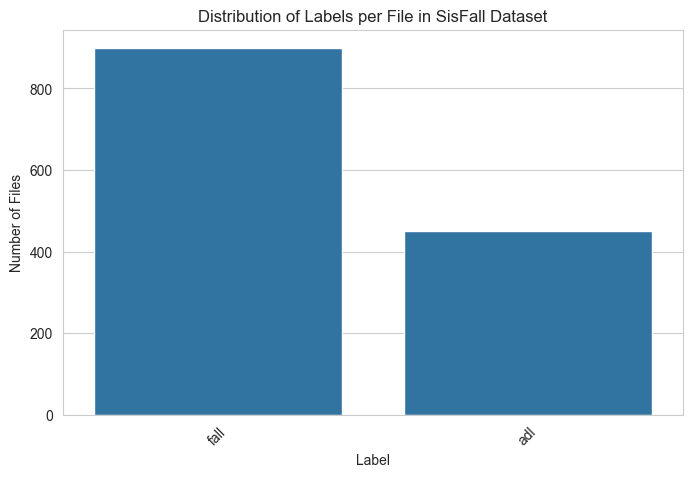

In [50]:
# Check the distribution of labels per file
file_label_counts = sisfall_data[['filename', 'label']].drop_duplicates()['label'].value_counts()

# Print the distribution of labels per file
print("Distribution of labels per file:")
print(file_label_counts)

# Print the percentage of each label
total_files = file_label_counts.sum()
for label, count in file_label_counts.items():
    percentage = (count / total_files) * 100
    print(f"{label}: {count} files ({percentage:.2f}%)")

plt.figure(figsize=(8, 5))
sns.barplot(x=file_label_counts.index, y=file_label_counts.values)
plt.title('Distribution of Labels per File in SisFall Dataset')
plt.xlabel('Label')
plt.ylabel('Number of Files')
plt.xticks(rotation=45)
plt.show()

Distribution of labels:
label
adl     3065713
fall    2696866
Name: count, dtype: int64
adl: 3065713 samples (53.20%)
fall: 2696866 samples (46.80%)


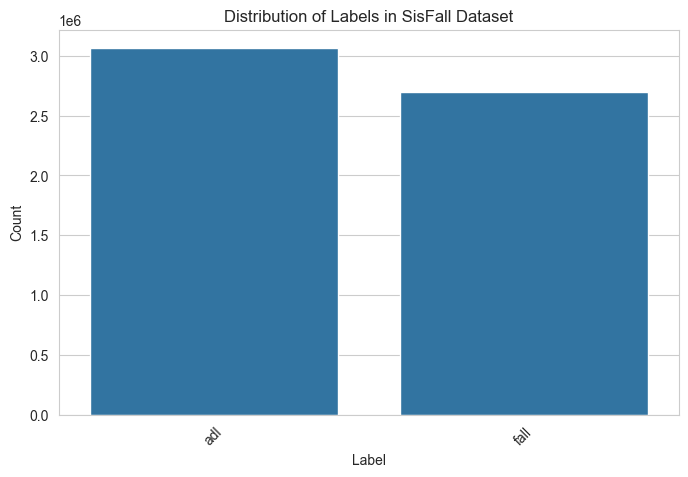

In [51]:
# Check the distribution of labels
label_counts = sisfall_data['label'].value_counts()

# Print the distribution of labels
print("Distribution of labels:")
print(label_counts)

# Print the percentage of each label
total_samples = label_counts.sum()
for label, count in label_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{label}: {count} samples ({percentage:.2f}%)")

plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Labels in SisFall Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [52]:
# Save the dataset to a CSV file
sisfall_data.to_csv('reduced_sisfall_dataset.csv', index=False)